In [1]:
# imports necessary modules
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler

import os, gc, random, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_auc_score, confusion_matrix

from pathlib import Path
warnings.filterwarnings('ignore')

### Data

In [2]:
#df_train = pd.read_csv("./data/pre_processed_df_train.csv",sep='\t', encoding='utf-8', nrows=75000)
df_train = pd.read_csv("./data/pre_processed_df_train.csv",sep='\t', encoding='utf-8')

In [3]:
# y class lables.
y = df_train['TARGET'].values

In [4]:
remove_cols=['Unnamed: 0','SK_ID_CURR','TARGET']
df_train.drop(columns=remove_cols,axis=1,inplace=True)

In [5]:
categorical_features=df_train.select_dtypes(include=object).columns.to_list()
print('# of categorical columns~~> {}'.format(len(categorical_features)))

numerical_features=df_train.select_dtypes(exclude=object).columns.to_list()
print('# of Numerical columns~~> {}'.format(len(numerical_features)))

# of categorical columns~~> 38
# of Numerical columns~~> 961


In [6]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5439091430067283, 1: 6.193575025176234}

#### Train, Validation and Test Split

In [7]:
#split categorical data only train and test. 
X_tr, X_test, y_tr, y_test = train_test_split(df_train, y, test_size=0.33, stratify=y,random_state=42)
X_train,X_val,y_train,y_val =train_test_split(X_tr,y_tr,test_size=0.33,stratify=y_tr,random_state=42)

In [8]:
# index of the categorical features
cat_indexes = [column_index for column_index, column_name in enumerate(df_train.columns) if column_name in categorical_features]
# dimensions of each categorical feature
cat_dimensions = df_train[categorical_features].nunique().tolist()

In [9]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

cat_embedding_dim=[max_length(df_train[cat]) for cat in categorical_features]
#print(cat_embedding_dim)

### vectorization - Categorical Features

In [10]:
from sklearn.preprocessing import LabelEncoder
# Numeric columns will be scaled by StandardScaler
#scaler = StandardScaler()
# Categorical will be transformed using Weight of Evidence approach
l_enc = LabelEncoder()

types = df_train.dtypes
categorical_columns = {}
categorical_dims =  {}
for idx,col in enumerate(tqdm(df_train.columns)):
    if types[col] == 'object': #categorical values
        l_enc = LabelEncoder()
        X_train[col] = l_enc.fit_transform(X_train[col].values)
        X_val[col] = l_enc.fit_transform(X_val[col].values)
        X_test[col] = l_enc.fit_transform(X_test[col].values)


100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 368.34it/s]


In [11]:
gc.enable()
del X_tr,df_train
gc.collect()

57

In [12]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [13]:
print(X_train.shape,X_val.shape,X_test.shape)

(138041, 999) (67991, 999) (101479, 999)


In [14]:
y_train.shape

(138041,)

### Model TabNet

In [15]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import datetime
import random as rn

os.environ['PYTHONHASHSEED'] = '0'
## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

#clear the session 
tf.keras.backend.clear_session()

#max_epochs 30
max_epochs = 30 if not os.getenv("CI", False) else 2

#Model
X_tr,X_cv,y_tr,y_cv =train_test_split(X_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

#n_d [Width of the decision prediction layer.] = 8 -64 default is 8
#n_a [Width of the attention embedding for each mask.] = 8 -64 default is 8
#n_steps : [Number of steps in the architecture (usually between 3 and 10)]. default=3
#gamma : [This is the coefficient for feature reusage in the masks.]. default=1.3.Values range from 1.0 to 2.0.
#cat_idxs :(default=[] - Mandatory for embeddings).List of categorical features indices.
#cat_dims :(default=[] - Mandatory for embeddings). List of categorical features number of modalities
#cat_emb_dim : list of int. List of embeddings size for each categorical features. (default =1)
#n_independent : (default=2).[Number of independent Gated Linear Units layers at each step. Usual values range from 1 to 5.]
#n_shared : int (default=2). [Number of shared Gated Linear Units at each step Usual values range from 1 to 5].
#momentum : [Momentum for batch normalization, typically ranges from 0.01 to 0.4 ] (default=0.02)
#clip_value : 0.95 [If a float is given this will clip the gradient at clip_value.]
#lambda_sparse : (default = 1e-3): [This is the extra sparsity loss coefficient as proposed in the original paper]
#optimizer_fn : torch.optim (default=torch.optim.Adam)
#optimizer_params: dict (default=dict(lr=2e-2))
#scheduler_fn : torch.optim.lr_scheduler (default=None)

tabnet_params = {
                    'n_d': 32, 'n_a': 32, 'n_steps': 5,'gamma':1.4, 
                    'cat_idxs':cat_indexes,
                    'cat_dims':cat_dimensions, 
                    'cat_emb_dim': cat_embedding_dim,
                    'n_independent': 2, 
                    'n_shared': 2, 'epsilon': 1e-15, 
                    'momentum': 0.05, 'verbose': 1, 
                    'optimizer_fn': torch.optim.Adam, 
                    'optimizer_params': dict(lr=1.9e-2), 
                    'scheduler_fn': torch.optim.lr_scheduler.StepLR, 
                    'scheduler_params': {"step_size":20,'gamma':0.95}, 
                    'mask_type': 'entmax', #sparsemax
                    'input_dim': X_train.shape[1], 
                    'output_dim': 2, 
                    'device_name': 'auto',
                    'lambda_sparse': 1.2e-4,
                    'clip_value' : 2.0
                }

unsupervised_model = TabNetPretrainer(**tabnet_params )
unsupervised_model.fit(X_train=np.array(X_tr),eval_set=[np.array(X_cv)]
                       ,pretraining_ratio=0.8 ,max_epochs=max_epochs , patience=3
                       ,batch_size=1024, virtual_batch_size=256,num_workers=0
                       ,drop_last=False)

#save unsupervised model
unsupervised_model.save_model('./results/test_pretrain')

Device used : cpu
epoch 0  | loss: 1179224260372410.5| val_0_unsup_loss: 8514.125|  0:01:22s
epoch 1  | loss: 1153366112171267.0| val_0_unsup_loss: 584.07562|  0:02:44s
epoch 2  | loss: 1175375222225109.8| val_0_unsup_loss: 387.67023|  0:04:07s
epoch 3  | loss: 2312384226626707.0| val_0_unsup_loss: 1833.19604|  0:05:32s
epoch 4  | loss: 3449872097100011.5| val_0_unsup_loss: 7389.73291|  0:06:56s
epoch 5  | loss: 24471.51838| val_0_unsup_loss: 2303.71973|  0:08:20s

Early stopping occurred at epoch 5 with best_epoch = 2 and best_val_0_unsup_loss = 387.67023
Best weights from best epoch are automatically used!
Successfully saved model at ./results/test_pretrain.zip


'./results/test_pretrain.zip'

In [16]:
gc.enable()
del X_tr,X_cv,y_tr,y_cv
gc.collect()

0

In [17]:
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./results/test_pretrain.zip')

Device used : cpu
Device used : cpu


In [18]:
clf = TabNetClassifier(**tabnet_params)
model_history=clf.fit(X_train=np.array(X_train), y_train=np.array(y_train), 
                   eval_set=[(np.array(X_train), np.array(y_train)), (np.array(X_val), np.array(y_val))],
                   eval_name=['train', 'valid'], eval_metric=['auc'], 
                   from_unsupervised=loaded_pretrain,
                   max_epochs=max_epochs , patience=3,
                   batch_size=1024, virtual_batch_size=256,
                   num_workers=0,
                   drop_last=False,
                   #weights=d_class_weights
                   weights=1 # No sampling
                  )

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 0.64268 | train_auc: 0.70845 | valid_auc: 0.70346 |  0:03:59s
epoch 1  | loss: 0.61918 | train_auc: 0.72309 | valid_auc: 0.71882 |  0:07:58s
epoch 2  | loss: 0.61387 | train_auc: 0.72855 | valid_auc: 0.72288 |  0:11:56s
epoch 3  | loss: 0.60551 | train_auc: 0.74198 | valid_auc: 0.73355 |  0:15:54s
epoch 4  | loss: 0.59123 | train_auc: 0.75004 | valid_auc: 0.7345  |  0:19:52s
epoch 5  | loss: 0.59724 | train_auc: 0.74146 | valid_auc: 0.73019 |  0:23:50s
epoch 6  | loss: 0.59386 | train_auc: 0.75883 | valid_auc: 0.74616 |  0:27:48s
epoch 7  | loss: 0.58146 | train_auc: 0.75913 | valid_auc: 0.74696 |  0:31:47s
epoch 8  | loss: 0.588   | train_auc: 0.75374 | valid_auc: 0.74386 |  0:35:44s
epoch 9  | loss: 0.58414 | train_auc: 0.76881 | valid_auc: 0.75412 |  0:39:41s
epoch 10 | loss: 0.57946 | train_auc: 0.76982 | valid_auc: 0.75728 |  0:43:38s
epoch 11 | loss: 0.57601 | train_auc: 0.76962 | valid_auc: 0.75868 

In [19]:
#save unsupervised model
clf.save_model('./results/tabnet_trained_model')
loaded_clf = TabNetClassifier()
loaded_clf.load_model('./results/tabnet_trained_model.zip')

Successfully saved model at ./results/tabnet_trained_model.zip
Device used : cpu
Device used : cpu


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix

sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')

In [21]:
X_train = np.vstack((X_train,X_val))
y_train = np.concatenate([y_train,y_val],axis=0)
print(y_train.shape,X_train.shape)

(206032,) (206032, 999)


#### AUC curve

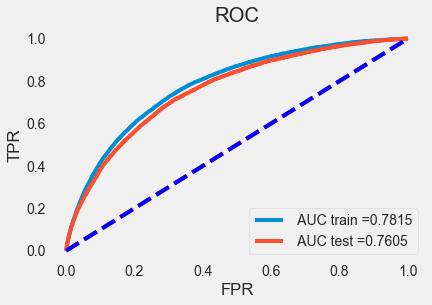

0.7814990884567836 0.7605043259320448


In [22]:
from sklearn.metrics import roc_curve

#train data predict
y_tr_pred = loaded_clf.predict_proba(np.array(X_train))

#test data predict
y_te_pred = loaded_clf.predict_proba(np.array(X_test))

#fpr,tpr,thresholds 
fpr, tpr, thresholds = roc_curve(np.array(y_train), y_tr_pred[:, 1])
#auc score train score
auc_train = roc_auc_score(np.array(y_train), y_tr_pred[:, 1])

plt.plot(fpr, tpr, label=" AUC train ="+str("{:.4f}".format(auc_train)))
plt.plot([0, 1], [0, 1],'r--')
    
fpr, tpr, thresholds = roc_curve(np.array(y_test), y_te_pred[:, 1])
#auc score test score
auc_test = roc_auc_score(np.array(y_test), y_te_pred[:, 1])
plt.plot(fpr, tpr, label=" AUC test ="+str("{:.4f}".format(auc_test)))
plt.plot([0, 1], [0, 1],'b--')

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC" )
plt.grid()
plt.show()

print(auc_train,auc_test)

#### plot Train vs Validation loss

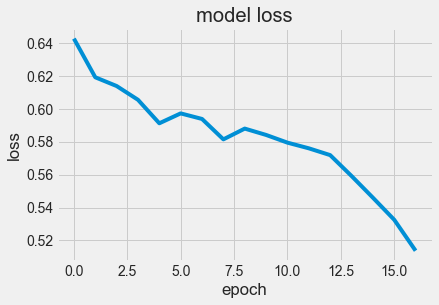

In [23]:
# summarize history for loss
plt.plot(clf.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### AUC at each epoch ends

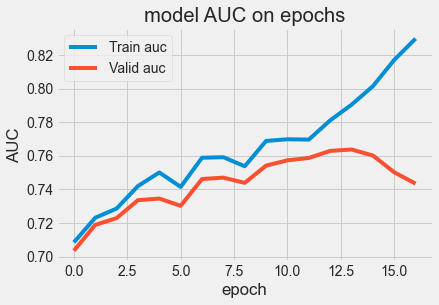

In [24]:
# plot auc
plt.plot(clf.history['train_auc'], label="Train auc")
plt.plot(clf.history['valid_auc'], label="Valid auc")
plt.title('model AUC on epochs')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend()
plt.show()

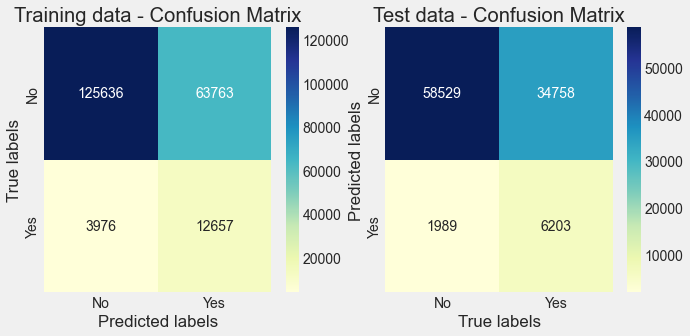

In [25]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plot_confusionmatrix(y_tr,y_trpred,y_te,y_tepred):
    from sklearn.metrics import confusion_matrix
    #tn, fp, fn, tp = confusion_matrix(y_tr, np.round(y_trpred)).ravel()    
    #print('Traiing data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    #confusion matrix on training data 
    plt.figure(figsize=(10, 10))
    ax_tr = plt.subplot(221)
    cm_tr = confusion_matrix(y_tr, np.round(y_trpred))
    plt.title("Training data - Confusion Matrix")
    sns.heatmap(cm_tr, ax=ax_tr, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_tr.set_xlabel('Predicted labels');
    ax_tr.set_ylabel('True labels'); 
    ax_tr.set_ylim(2.0, 0)
    ax_tr.xaxis.set_ticklabels(['No','Yes']); 
    ax_tr.yaxis.set_ticklabels(['No','Yes']);
    
    #Confusion matrix on test data
    #tn, fp, fn, tp = confusion_matrix(y_te, np.round(y_tepred)).ravel()    
    #print('Training data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    
    ax_te = plt.subplot(222)
    cm_te = confusion_matrix(y_te, np.round(y_tepred))
    plt.title("Test data - Confusion Matrix")
    sns.heatmap(cm_te, ax=ax_te, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_te.set_ylabel('Predicted labels');
    ax_te.set_xlabel('True labels'); 
    ax_te.set_ylim(2.0, 0)
    ax_te.xaxis.set_ticklabels(['No','Yes']); 
    ax_te.yaxis.set_ticklabels(['No','Yes']);

    plt.show()
    return
plot_confusionmatrix(y_train,y_tr_pred[:,1],y_test,y_te_pred[:,1])

In [26]:
y_tr_pred_classes =np.round(y_tr_pred[:,1]).reshape(-1,1).astype(int)
y_te_pred_classes = np.round(y_te_pred[:,1]).reshape(-1,1).astype(int)

target_names=np.unique(y_tr_pred_classes).astype(int).astype(str)

from sklearn.metrics import classification_report
print("Train Results")
print("*"*55)
print(classification_report(y_train,y_tr_pred_classes, target_names= target_names))
print("*"*55)
print("Test Results")
print("*"*55)
print(classification_report(y_test,y_te_pred_classes, target_names=target_names))

Train Results
*******************************************************
              precision    recall  f1-score   support

           0       0.97      0.66      0.79    189399
           1       0.17      0.76      0.27     16633

    accuracy                           0.67    206032
   macro avg       0.57      0.71      0.53    206032
weighted avg       0.90      0.67      0.75    206032

*******************************************************
Test Results
*******************************************************
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     93287
           1       0.15      0.76      0.25      8192

    accuracy                           0.64    101479
   macro avg       0.56      0.69      0.51    101479
weighted avg       0.90      0.64      0.72    101479



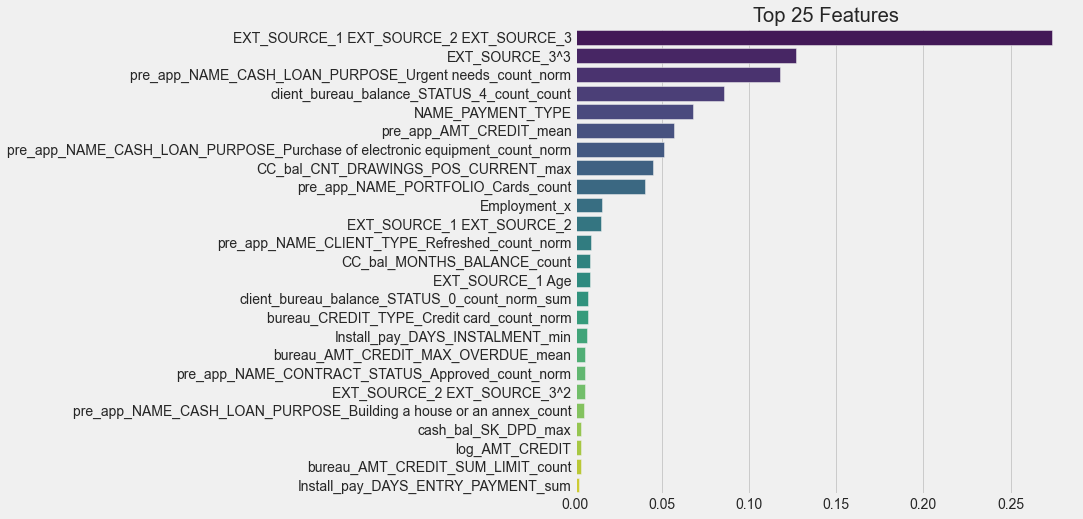

In [27]:
#Global explainability : feat importance summing to 1
top20_feature_names=[]
feature_importance = clf.feature_importances_
feature_importances = (clf.feature_importances_ / sum(clf.feature_importances_+0.000001)) * 100
indices = feature_importance.argsort()[::-1][:25]
for i in indices:
    top20_feature_names.append(X_test.columns[i])

#Plot bar plot for top 20 features
plt.close()
column =top20_feature_names
score = feature_importance[indices]
plt.figure(figsize =(8, 8))
sns.barplot(x=score, y=column, palette="viridis")
plt.xticks(rotation=0)
plt.title('Top 25 Features')
plt.show()

In [28]:
# http://zetcode.com/python/prettytable/
top50_feature_names=[]
feature_importance = clf.feature_importances_
feature_importances = (clf.feature_importances_ / sum(clf.feature_importances_+0.000001)) * 100
indices = feature_importance.argsort()[::-1][:25]
for i in indices:
    top50_feature_names.append(X_test.columns[i])
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Feature","Score"]
column =top50_feature_names
score = feature_importance[indices]
for val in zip(column,score):
    x.add_row([val[0],np.round(val[1],4)])
x.sortby = "Score"
x.reversesort = True
x.align["Feature"] = "l"
x.align["Score"] = "r"
print(x)


+----------------------------------------------------------------------------+--------+
| Feature                                                                    |  Score |
+----------------------------------------------------------------------------+--------+
| EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3                                     | 0.2739 |
| EXT_SOURCE_3^3                                                             |  0.127 |
| pre_app_NAME_CASH_LOAN_PURPOSE_Urgent needs_count_norm                     | 0.1175 |
| client_bureau_balance_STATUS_4_count_count                                 | 0.0853 |
| NAME_PAYMENT_TYPE                                                          | 0.0676 |
| pre_app_AMT_CREDIT_mean                                                    | 0.0569 |
| pre_app_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_count_norm | 0.0511 |
| CC_bal_CNT_DRAWINGS_POS_CURRENT_max                                        | 0.0447 |
| pre_app_NAME_PORTFOLIO_Cards_c